In [1]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from copy import deepcopy
import matplotlib.pyplot as plt
import torch.nn as nn
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import os
import sys
import matplotlib.pyplot as plt

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")

from env import SumoEnvironment
from sumo_rl.agents import QLAgent
from sumo_rl.exploration import EpsilonGreedy

from custom_observation import CustomEmergencyObservationFunction
from custom_reward import emergency_reward_fn

In [8]:
class DQNetwork(nn.Module):
    def __init__(self, inp_size, op_size):
        super(DQNetwork, self).__init__()
        self.activation = nn.ReLU()
        self.hl1 = nn.Linear(inp_size, 128)
        self.hl2 = nn.Linear(128, 128)
        self.fc = nn.Linear(128, op_size)
        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.xavier_normal_(self.hl1.weight)
        torch.nn.init.xavier_normal_(self.hl2.weight)
        torch.nn.init.xavier_normal_(self.fc.weight)
        torch.nn.init.zeros_(self.hl1.bias)
        torch.nn.init.zeros_(self.hl2.bias)
        torch.nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        x = self.hl1(x)
        x = self.activation(x)
        x = self.hl2(x)
        x = self.activation(x)
        x = self.fc(x)
        return x

In [9]:
class GreedyAgent:
    
    def __init__(self, model, env, initial_epsilon, epsilon_decay, final_epsilon, discount_factor, num_episodes=1000):
        self.env = env
        self.model = model
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
    def step(self, obs, train=True):
        if train:
            if np.random.random() < self.epsilon:
                return self.action_space.sample()
            else:
                self.model.eval()
                with torch.no_grad():
                    output = self.model(torch.from_numpy(obs['t']).to(dtype=torch.float32))
                    return torch.argmax(output).item()
        else:
            self.model.eval()
            with torch.no_grad():
                output = self.model(torch.from_numpy(obs['t']).to(dtype=torch.float32))
                return torch.argmax(output).item()
        

    def decay(self):
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

In [10]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=False,
        num_seconds=5000,
        min_green=5,
        max_green=10,
        observation_class = CustomEmergencyObservationFunction,
        reward_fn = emergency_reward_fn
    )

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 0 ACT 0 BUF 0)                      


In [11]:
# training params
BUFFER_SIZE = 500
batch_size = 32
sync_target_step = 4
train_every_step = 3
episodes = 10
replay_buffer = torch.zeros((BUFFER_SIZE, 9 + 1 + 1 + 9 + 1), dtype = torch.float32) #[sx9, a, r, s'x9, terminate flag]
learning_rate = 0.001

#agent params
start_epsilon = 0.9
final_epsilon = 0.01
epsilon_decay = (final_epsilon/start_epsilon)**(1/episodes)  # exponential decay
discount_factor = 0.99

# model init
model = DQNetwork(env.observation_space.shape[0], env.action_space.n)
target_model = deepcopy(model)

agent = GreedyAgent(model, env, start_epsilon, epsilon_decay, final_epsilon, discount_factor)

# optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [12]:
n_iters = 0 
train_loss = []
reward_per_episode = [0] * episodes
epsilon_per_episode = [0] * episodes
steps_per_episode = [0] * episodes
wait_per_episode_lane_1 = [0] * episodes
wait_per_episode_lane_2 = [0] * episodes
for episode in range(episodes):
    obs = env.reset()
    done = {"__all__": False}
    epsilon_per_episode[episode] = agent.epsilon
    batch_loss = []
    t = 0
    lane_1_wt, lane_2_wt = 0, 0
    while not done["__all__"]:
        action = agent.step(obs)
        next_obs, reward, done, info = env.step({'t': action})

        if len(info["emergency_waiting_time"]) > 0:
            for k,v in info["emergency_waiting_time"].items():
                if k == "flow_emergency_ns_1":
                    wait_per_episode_lane_1[episode] += v
                elif k == "flow_emergency_ns_2":
                    wait_per_episode_lane_2[episode] += v
        
        n_iters = n_iters + 1
        
        reward_per_episode[episode] += reward['t']
        replay_buffer[n_iters % BUFFER_SIZE] = torch.cat([torch.from_numpy(obs['t']), torch.tensor([action], dtype=torch.int32), torch.tensor([reward['t']], dtype=torch.int32), torch.from_numpy(next_obs['t']), torch.tensor([int(done["__all__"])], dtype=torch.int32)]).to(torch.float32)
        
        obs = deepcopy(next_obs)
        t += 1
    
    steps_per_episode[episode] += t
    agent.decay()
    env.close()
    
    if n_iters >= batch_size and episode % train_every_step == 0:

        selected_transition_indices = torch.randint(low=0, high=min(n_iters, BUFFER_SIZE), size=(batch_size, ))
        selected_transition = replay_buffer[selected_transition_indices]  #selected_transition: [sx9, a, r, s'x9, terminate flag]

        td_target = torch.zeros(batch_size)
        next_obs = selected_transition[:, 11:-1]
        target_model.eval()
        with torch.no_grad():
            target_output = target_model(next_obs)
            q_values, _ = torch.max(target_output, dim = 1)
            td_target = torch.where(selected_transition[:, -1] == True, selected_transition[:, 10], selected_transition[:, 10] + discount_factor * q_values)

        model.train()
        obs = selected_transition[:, :9]
        output = model(obs)
        td_estimate = output.gather(1, selected_transition[:, 9][:, None].type(torch.int64)).squeeze(1)
        loss = criterion(td_target, td_estimate)

        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if(episode % sync_target_step == 0):
        target_model.load_state_dict(model.state_dict())

 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 49ms, vehicles TOT 3123 ACT 39 BUF 465)             tep #4900.00 (1ms ~= 1000.00*RT, ~46000.00UPS, TraCI: 60ms, vehicles TOT 3056 ACT 46 BUF 
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 73ms, vehicles TOT 3456 ACT 40 BUF 87)              
 Retrying in 1 seconds


Step #5000.00 (1ms ~= 1000.00*RT, ~48000.00UPS, TraCI: 68ms, vehicles TOT 3515 ACT 48 BUF 
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 82ms, vehicles TOT 3187 ACT 54 BUF 360)             tep #4500.00 (0ms ?*RT. ?UPS, TraCI: 77ms, vehicles TOT 2863 ACT 52 BUF 317)             
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~40000.00UPS, TraCI: 59ms, vehicles TOT 3553 ACT 40 BUF tep #4500.00 (1ms ~= 1000.00*RT, ~40000.00UPS, TraCI: 60ms, vehicles TOT 3190 ACT 40 BUF 
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 65ms, vehicles TOT 3240 ACT 43 BUF 309)             tep #4500.00 (0ms ?*RT. ?UPS, TraCI: 86ms, vehicles TOT 2965 ACT 54 BUF 237)             
 Retrying in 1 seconds


Step #5000.00 (1ms ~= 1000.00*RT, ~40000.00UPS, TraCI: 55ms, vehicles TOT 3508 ACT 40 BUF 
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 48ms, vehicles TOT 3236 ACT 35 BUF 299)             
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 55ms, vehicles TOT 3235 ACT 34 BUF 300)             
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 60ms, vehicles TOT 3209 ACT 40 BUF 264)             


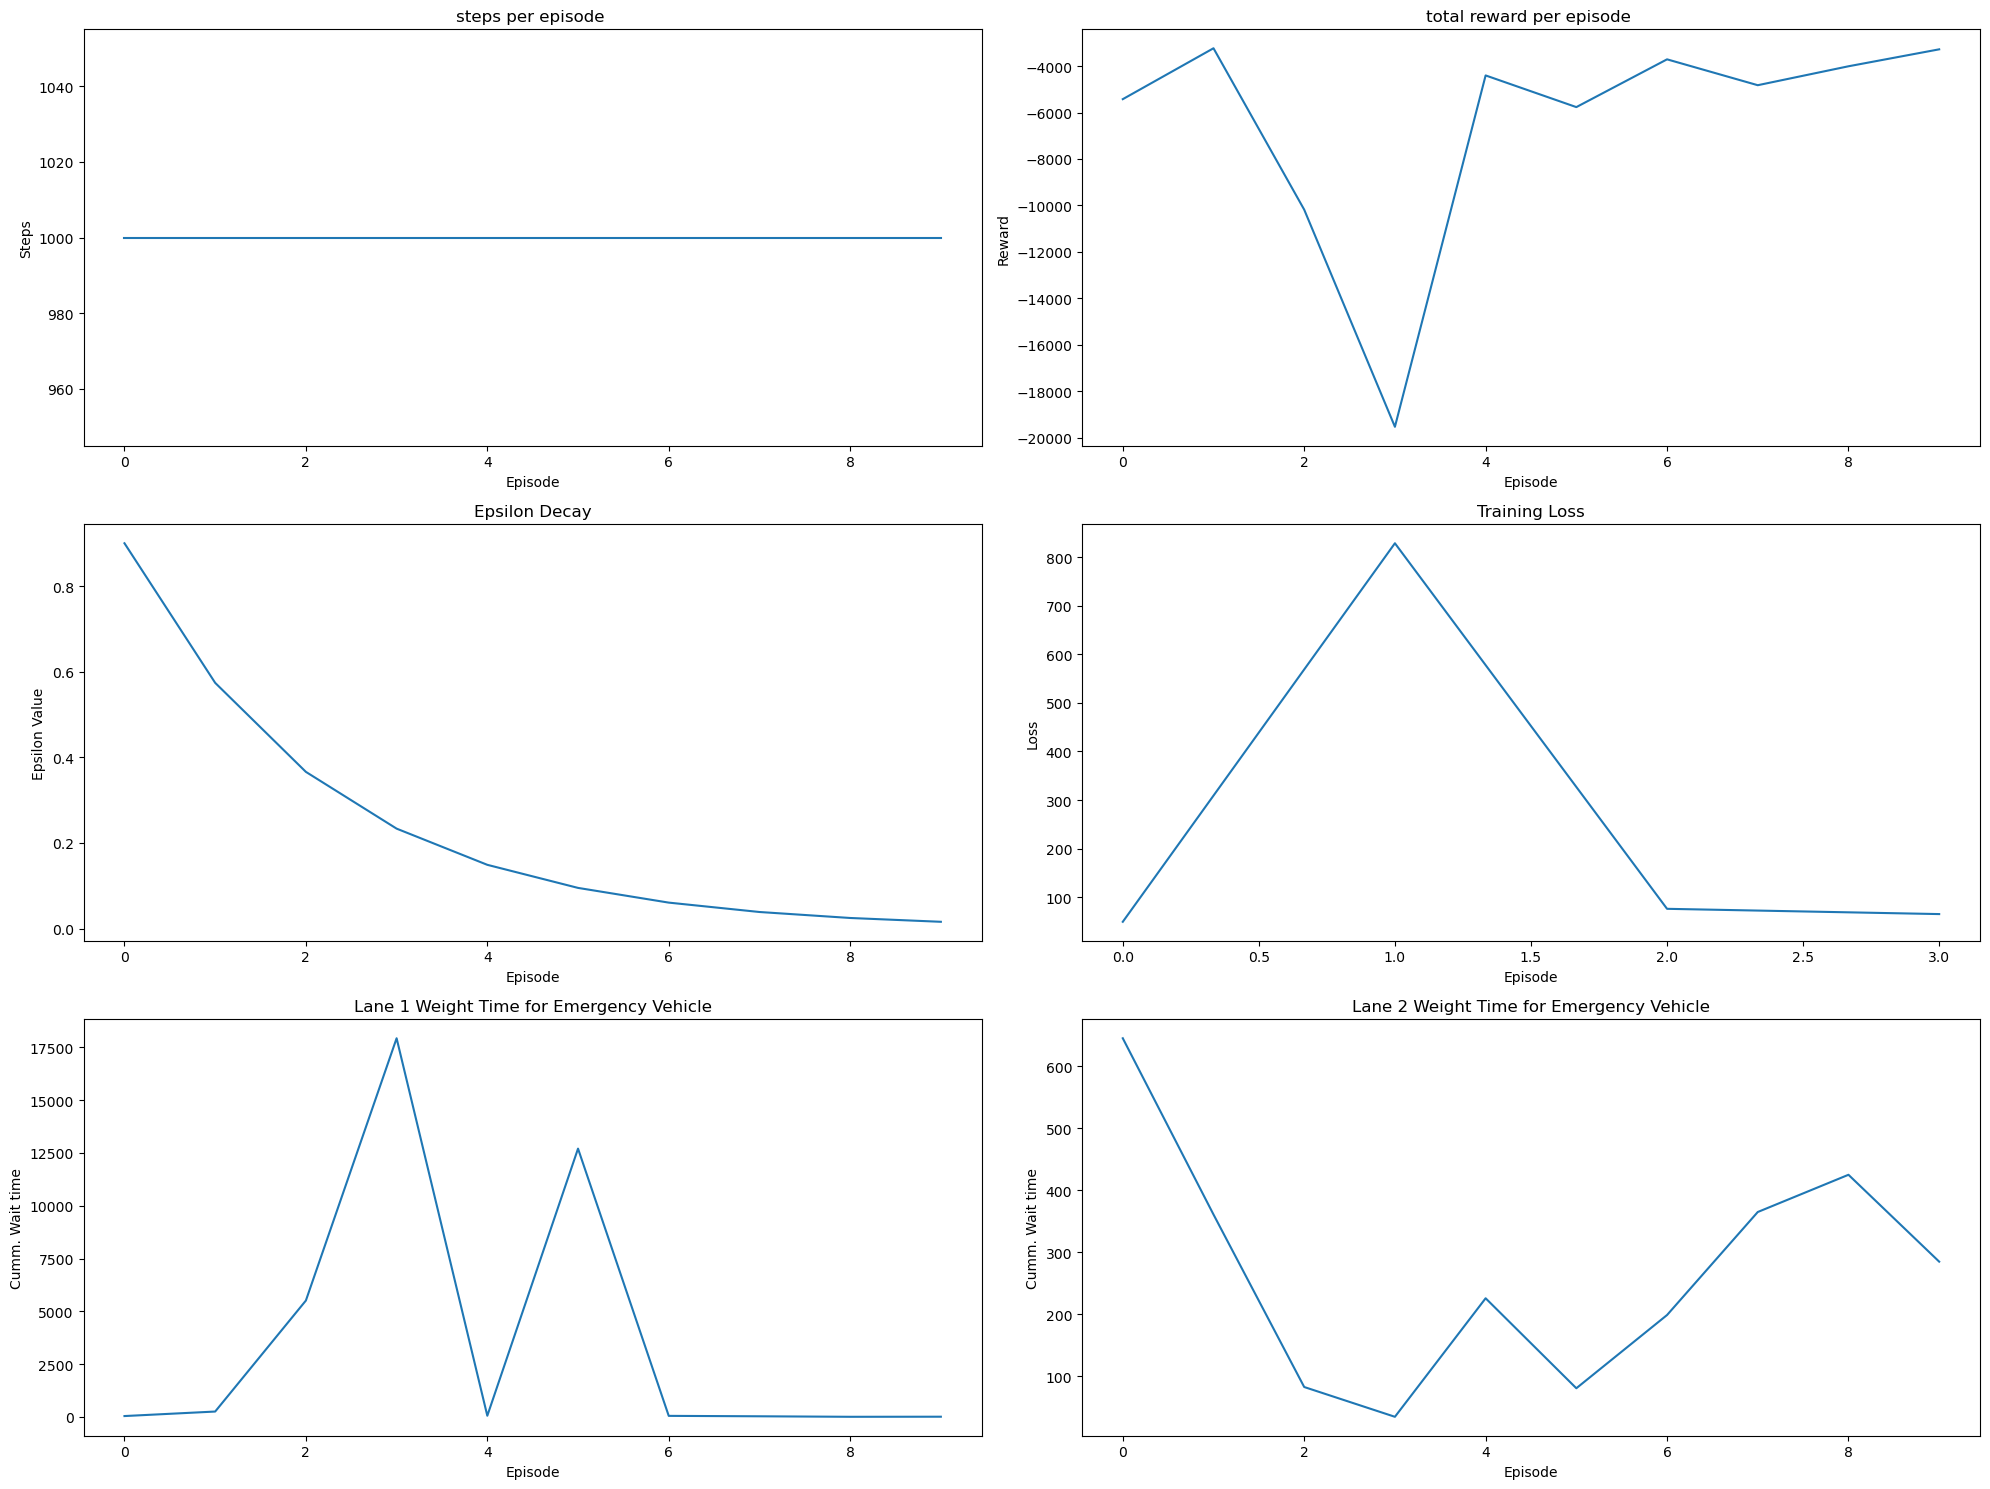

In [14]:
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

axs[0, 0].plot(range(episodes), steps_per_episode)
axs[0, 0].set_title("steps per episode ")
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Steps")

axs[0, 1].plot(range(episodes), reward_per_episode)
axs[0, 1].set_title("total reward per episode ")
axs[0, 1].set_xlabel("Episode")
axs[0, 1].set_ylabel("Reward")

axs[1, 0].plot(range(episodes), epsilon_per_episode)
axs[1, 0].set_title("Epsilon Decay")
axs[1, 0].set_xlabel("Episode")
axs[1, 0].set_ylabel("Epsilon Value")

axs[1, 1].plot(range(len(train_loss)), train_loss)
axs[1, 1].set_title("Training Loss")
axs[1, 1].set_xlabel("Episode")
axs[1, 1].set_ylabel("Loss")

axs[2, 0].plot(range(len(wait_per_episode_lane_1)), wait_per_episode_lane_1)
axs[2, 0].set_title("Lane 1 Weight Time for Emergency Vehicle")
axs[2, 0].set_xlabel("Episode")
axs[2, 0].set_ylabel("Cumm. Wait time")

axs[2, 1].plot(range(len(wait_per_episode_lane_2)), wait_per_episode_lane_2)
axs[2, 1].set_title("Lane 2 Weight Time for Emergency Vehicle")
axs[2, 1].set_xlabel("Episode")
axs[2, 1].set_ylabel("Cumm. Wait time")

plt.tight_layout()
plt.show()

In [15]:
n_episodes = 5
agent.epsilon = 0
reward_per_episode = [0]*n_episodes
wait_per_episode_lane_1 = [0] * episodes
wait_per_episode_lane_2 = [0] * episodes
for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}

    # play one episode
    while not done["__all__"]:
        action = agent.step(obs, train=False)
        next_obs, reward, done, info = env.step({'t': action})
        reward_per_episode[episode] += reward['t']
        obs = deepcopy(next_obs)

        if len(info["emergency_waiting_time"]) > 0:
            for k,v in info["emergency_waiting_time"].items():
                if k == "flow_emergency_ns_1":
                    wait_per_episode_lane_1[episode] += v
                elif k == "flow_emergency_ns_2":
                    wait_per_episode_lane_2[episode] += v

 Retrying in 1 seconds


Step #5000.00 (1ms ~= 1000.00*RT, ~39000.00UPS, TraCI: 53ms, vehicles TOT 2903 ACT 39 BUF 
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 48ms, vehicles TOT 2997 ACT 37 BUF 537)             
 Retrying in 1 seconds


Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 56ms, vehicles TOT 3060 ACT 40 BUF 522)             
 Retrying in 1 seconds


Step #5000.00 (1ms ~= 1000.00*RT, ~41000.00UPS, TraCI: 53ms, vehicles TOT 2978 ACT 41 BUF 
 Retrying in 1 seconds


Step #4800.00 (0ms ?*RT. ?UPS, TraCI: 53ms, vehicles TOT 2833 ACT 38 BUF 640)             

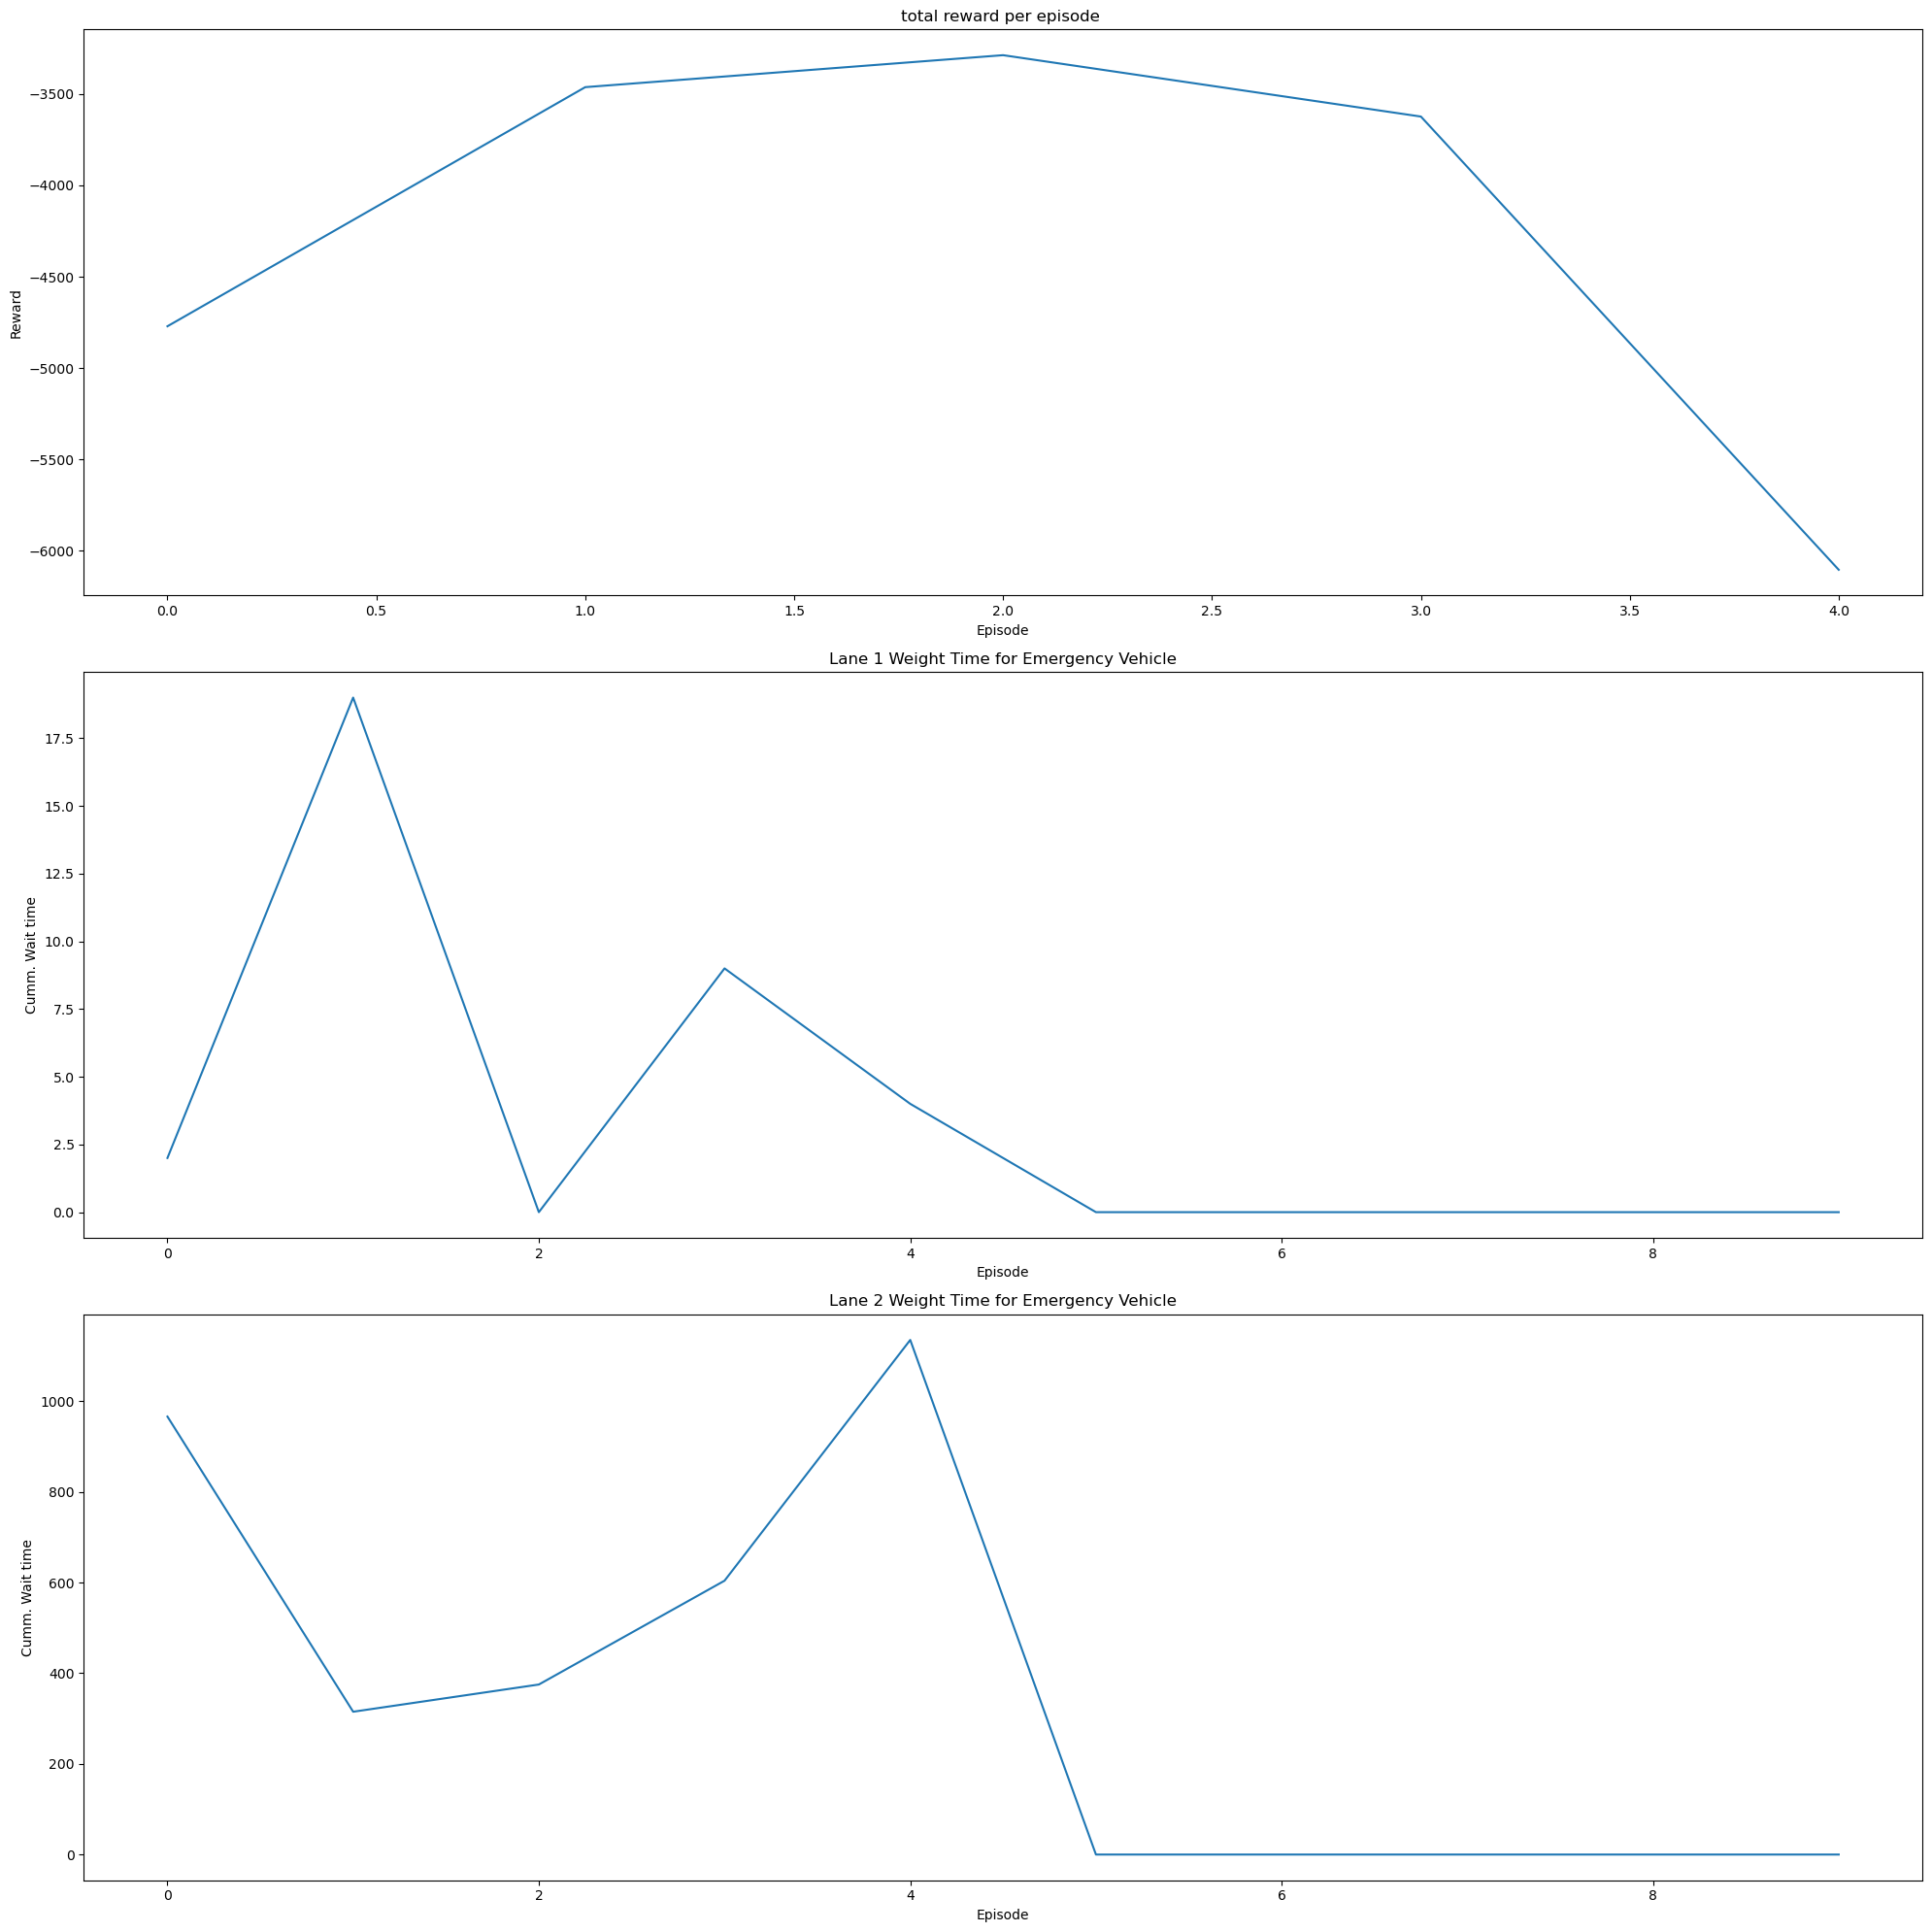

In [21]:
from matplotlib import pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(3, 1, figsize=(20, 20))

axs[0].plot(range(n_episodes), reward_per_episode)
axs[0].set_title("total reward per episode ")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(range(len(wait_per_episode_lane_1)), wait_per_episode_lane_1)
axs[1].set_title("Lane 1 Weight Time for Emergency Vehicle")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Cumm. Wait time")

axs[2].plot(range(len(wait_per_episode_lane_2)), wait_per_episode_lane_2)
axs[2].set_title("Lane 2 Weight Time for Emergency Vehicle")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Cumm. Wait time")

plt.tight_layout()
plt.show()

In [23]:
torch.save(model.state_dict(), "emergency_dqn.pth")

In [24]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=True,
        num_seconds=5000,
        min_green=5,
        max_green=10,
        observation_class = CustomEmergencyObservationFunction,
        reward_fn = emergency_reward_fn
    )

n_episodes = 1
agent.epsilon = 0
reward_per_episode = [0]*n_episodes

for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}

    # play one episode
    while not done["__all__"]:
        action = agent.step(obs, train=False)
        next_obs, reward, done, _ = env.step({'t': action})
        reward_per_episode[episode] += reward['t']
        obs = deepcopy(next_obs)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds


In [25]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=True,
        num_seconds=5000,
        min_green=5,
        max_green=10,
        observation_class = CustomEmergencyObservationFunction,
        reward_fn = emergency_reward_fn
    )

n_episodes = 1
for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}
    while not done["__all__"]:
        next_obs, reward, done, _ = env.step({})

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
